# Market Regime Detection and Dynamic Asset Allocation using GMM and HMM Models

**Objective**

This project aims to identify and model market regimes (e.g., crisis, growth, stagnation) over time using Gaussian Mixture Models (GMM) and Hidden Markov Models (HMM). The goal is to develop a dynamic asset allocation strategy that adapts to changing economic conditions, outperforming passive strategies like Buy & Hold.


In [ ]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import seaborn as sns
import backtrader as bt
import yfinance as yf

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

from hmmlearn import hmm
from scipy.spatial.distance import cdist

### Data

In [2]:
path = r"/Users/thomascgd/Desktop/Data_Markets_Regimes.xlsx"
data = pd.read_excel(path, index_col='Date',parse_dates=True)
data.head()

,Equity,FX,Commodities,Rates,Inflation,Emerging Markets,US Corporate IG
Date,,,,,,,
1989-01-03,497.22,92.19,86.1484,8.75,120.5,133.46,398.50
1989-01-04,497.10,93.07,85.9986,8.75,NaN,134.40,399.61
1989-01-05,496.54,93.67,86.4802,8.75,NaN,135.22,399.06
1989-01-06,494.58,94.47,86.7015,8.75,NaN,135.88,398.62
1989-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12779 entries, 1989-01-03 to 2023-12-29
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Equity            9129 non-null   float64
 1   FX                9052 non-null   float64
 2   Commodities       8786 non-null   float64
 3   Rates             8992 non-null   float64
 4   Inflation         420 non-null    float64
 5   Emerging Markets  9129 non-null   float64
 6   US Corporate IG   8760 non-null   float64
dtypes: float64(7)
memory usage: 798.7 KB


### Data Manipulation

In [4]:
data['Inflation'] = data['Inflation'].ffill() # Monthly Inflation Data published on the last sunday of the month
data['Inflation'] = np.log(data['Inflation'] / data['Inflation'].shift(1))
data['Inflation'] = data['Inflation'].replace(0,pd.NA)
data['Inflation'] = data['Inflation'].ffill()

data.dropna(inplace=True) #Deleting the week ends that we have because of the inflation index. 
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8706 entries, 1989-01-31 to 2023-12-29
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Equity            8706 non-null   float64
 1   FX                8706 non-null   float64
 2   Commodities       8706 non-null   float64
 3   Rates             8706 non-null   float64
 4   Inflation         8706 non-null   float64
 5   Emerging Markets  8706 non-null   float64
 6   US Corporate IG   8706 non-null   float64
dtypes: float64(7)
memory usage: 544.1 KB


### Data ploting

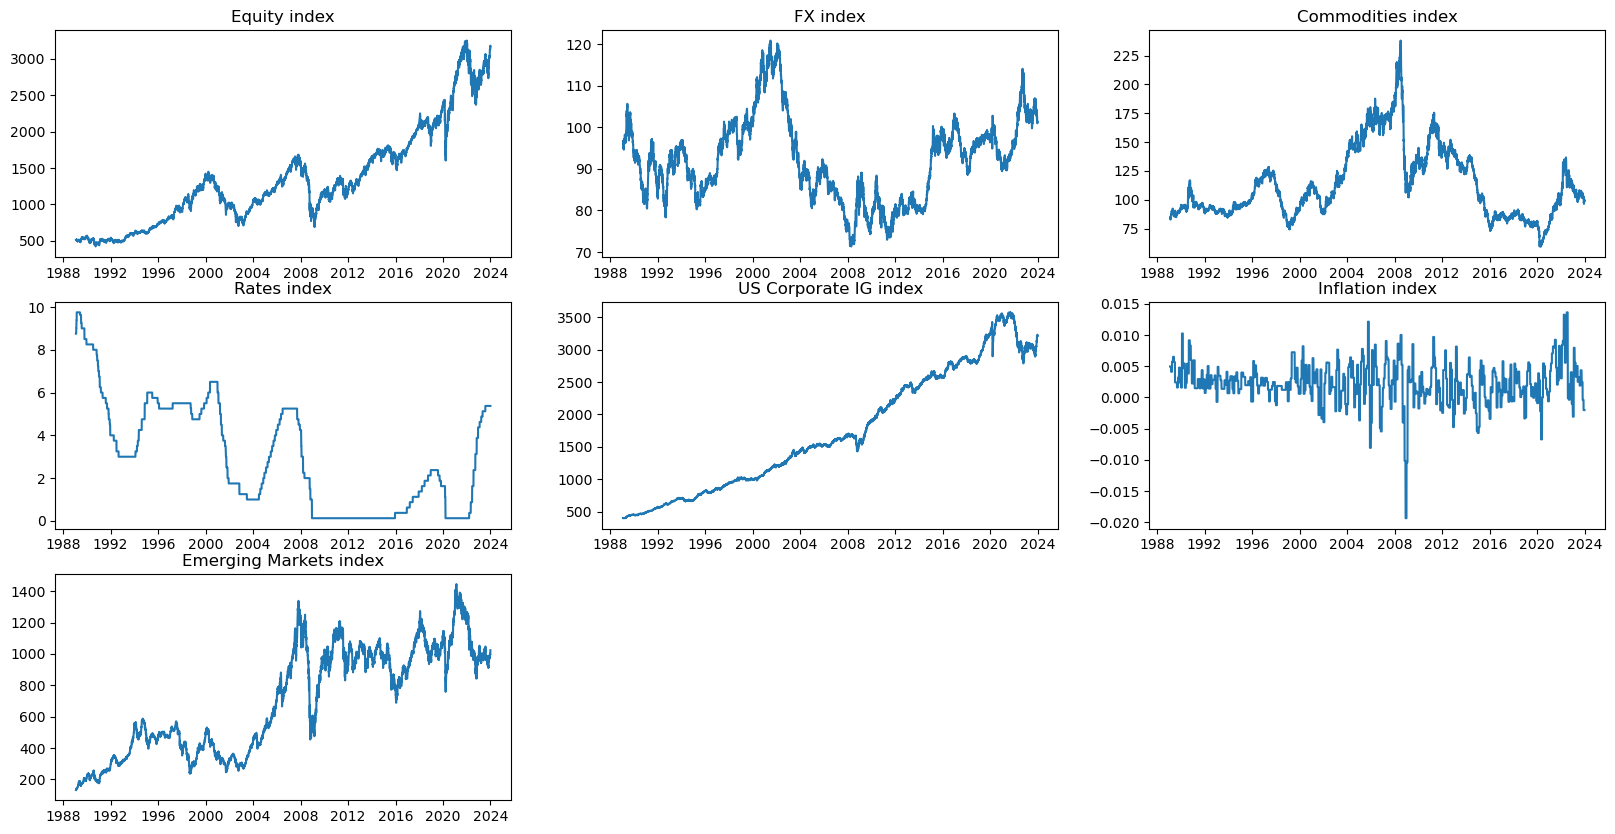

In [5]:
plt.figure(figsize=(20,10))

plt.subplot(3,3,1)
plt.plot(data["Equity"])
plt.title("Equity index")

plt.subplot(3,3,2)
plt.plot(data["FX"])
plt.title("FX index")

plt.subplot(3,3,3)
plt.plot(data["Commodities"])
plt.title("Commodities index")

plt.subplot(3,3,4)
plt.plot(data["Rates"])
plt.title("Rates index")

plt.subplot(3,3,5)
plt.plot(data["US Corporate IG"])
plt.title("US Corporate IG index")

plt.subplot(3,3,6)
plt.plot(data["Inflation"])
plt.title("Inflation index")

plt.subplot(3,3,7)
plt.plot(data["Emerging Markets"])
plt.title("Emerging Markets index")

plt.show()

### Data Standardization

In [6]:
data[['Equity','FX','Commodities','Emerging Markets','US Corporate IG']] = np.log(data[['Equity','FX','Commodities','Emerging Markets','US Corporate IG']] / data[['Equity','FX','Commodities','Emerging Markets','US Corporate IG']].shift(1))
data[['Equity','FX','Commodities','Inflation','Emerging Markets','US Corporate IG']] = data[['Equity','FX','Commodities','Inflation','Emerging Markets','US Corporate IG']] * 100 # in %
data.dropna(inplace=True)
data.head()

,Equity,FX,Commodities,Rates,Inflation,Emerging Markets,US Corporate IG
Date,,,,,,,
1989-02-01,-0.511560,0.051666,0.260001,8.75,0.49669,0.691109,0.044583
1989-02-02,0.155116,-0.030997,-0.101679,8.75,0.49669,1.094453,0.039613
1989-02-03,0.354489,-0.031006,-0.243012,8.75,0.49669,1.528430,0.071758
1989-02-06,-0.136946,-0.175883,-0.648356,8.75,0.49669,-0.065653,0.000000
1989-02-07,0.717856,0.041412,0.363759,8.75,0.49669,-0.094908,0.049458


In [7]:
data.describe()

,Equity,FX,Commodities,Rates,Inflation,Emerging Markets,US Corporate IG
count,8705.000000,8705.000000,8705.000000,8705.000000,8705.000000,8705.000000,8705.000000
mean,0.020952,0.000532,0.001751,2.942736,0.231960,0.023474,0.023859
std,0.968779,0.511402,0.942933,2.542817,0.339372,1.163544,0.341849
min,-10.441722,-2.726254,-9.170980,0.125000,-1.933869,-11.412592,-3.927471
25%,-0.411901,-0.288485,-0.494332,0.125000,0.066912,-0.522504,-0.160599
50%,0.061936,0.000000,0.032430,2.375000,0.225857,0.082712,0.034527
75%,0.491006,0.284969,0.512183,5.250000,0.434297,0.637211,0.219251
max,11.628673,2.805033,5.647463,9.750000,1.364259,12.952142,2.196795


## Identification of markets regimes


### Data Train - Test Split

### Parameters

In [8]:
separation_date = dt.datetime(2014,1,2)
start_date_train_index = data.index.get_loc(separation_date)

data_ref = data[data.index < separation_date]
scaler = StandardScaler()
data_ref_scaled = scaler.fit_transform(data_ref)

## Gaussian Mixture Model - GMM

#### AIC & BIC scores - GMM

AIC : best number of market regimes : 13
BIC : best number of market regimes : 13


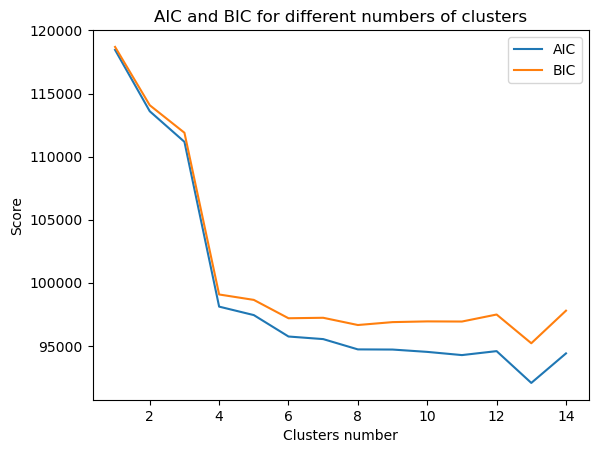

In [9]:
n_market_regimes = range(1, 15)
aic_scores = []
bic_scores = []

for market_regime in n_market_regimes:
    gmm = GaussianMixture(n_components=market_regime)
    gmm.fit(data_ref_scaled)
    aic_scores.append(gmm.aic(data_ref_scaled))
    bic_scores.append(gmm.bic(data_ref_scaled))

print(f"AIC : best number of market regimes : {aic_scores.index(min(aic_scores))+1}")
print(f"BIC : best number of market regimes : {bic_scores.index(min(bic_scores))+1}")

plt.plot(n_market_regimes, aic_scores, label='AIC')
plt.plot(n_market_regimes, bic_scores, label='BIC')
plt.xlabel('Clusters number')
plt.ylabel('Score')
plt.legend()
plt.title('AIC and BIC for different numbers of clusters')
plt.show()

#### Training the model

In [61]:
gmm_market_regimes = 4
reference_gmm = GaussianMixture(n_components=gmm_market_regimes, random_state=40, init_params='kmeans')
reference_gmm.fit(data_ref_scaled)
gmm_clusters = reference_gmm.predict(data_ref_scaled)
data_ref.loc[:,'GMM_MarketRegime'] = gmm_clusters

#### Characteristics of each market regimes

In [11]:
data_ref.groupby('GMM_MarketRegime').count() #represent the number of days in each market regimes.

,Equity,FX,Commodities,Rates,Inflation,Emerging Markets,US Corporate IG
GMM_MarketRegime,,,,,,,
0,513,513,513,513,513,513,513
1,3618,3618,3618,3618,3618,3618,3618
2,1239,1239,1239,1239,1239,1239,1239
3,837,837,837,837,837,837,837


In [12]:
for col in data_ref.columns[:-1]:
    print(col)
    print(data_ref.groupby('GMM_MarketRegime')[col].agg(['mean','min','max','std']))
    print('-'*30)

Equity
                      mean       min        max       std
GMM_MarketRegime                                         
0                -0.218079 -7.821784  11.628673  2.078792
1                 0.049969 -2.069817   2.471999  0.636846
2                 0.050655 -5.256135   4.967412  1.096811
3                -0.016593 -3.532998   2.982689  0.893154
------------------------------
FX
                      mean       min       max       std
GMM_MarketRegime                                        
0                -0.060519 -2.726254  2.805033  0.889549
1                 0.013072 -1.816713  1.955521  0.478912
2                -0.000450 -1.809148  1.828500  0.528518
3                -0.041407 -1.517847  1.636896  0.508385
------------------------------
Commodities
                      mean       min       max       std
GMM_MarketRegime                                        
0                -0.200570 -9.170980  5.647463  1.789305
1                 0.018536 -2.478623  2.544130  0.67042

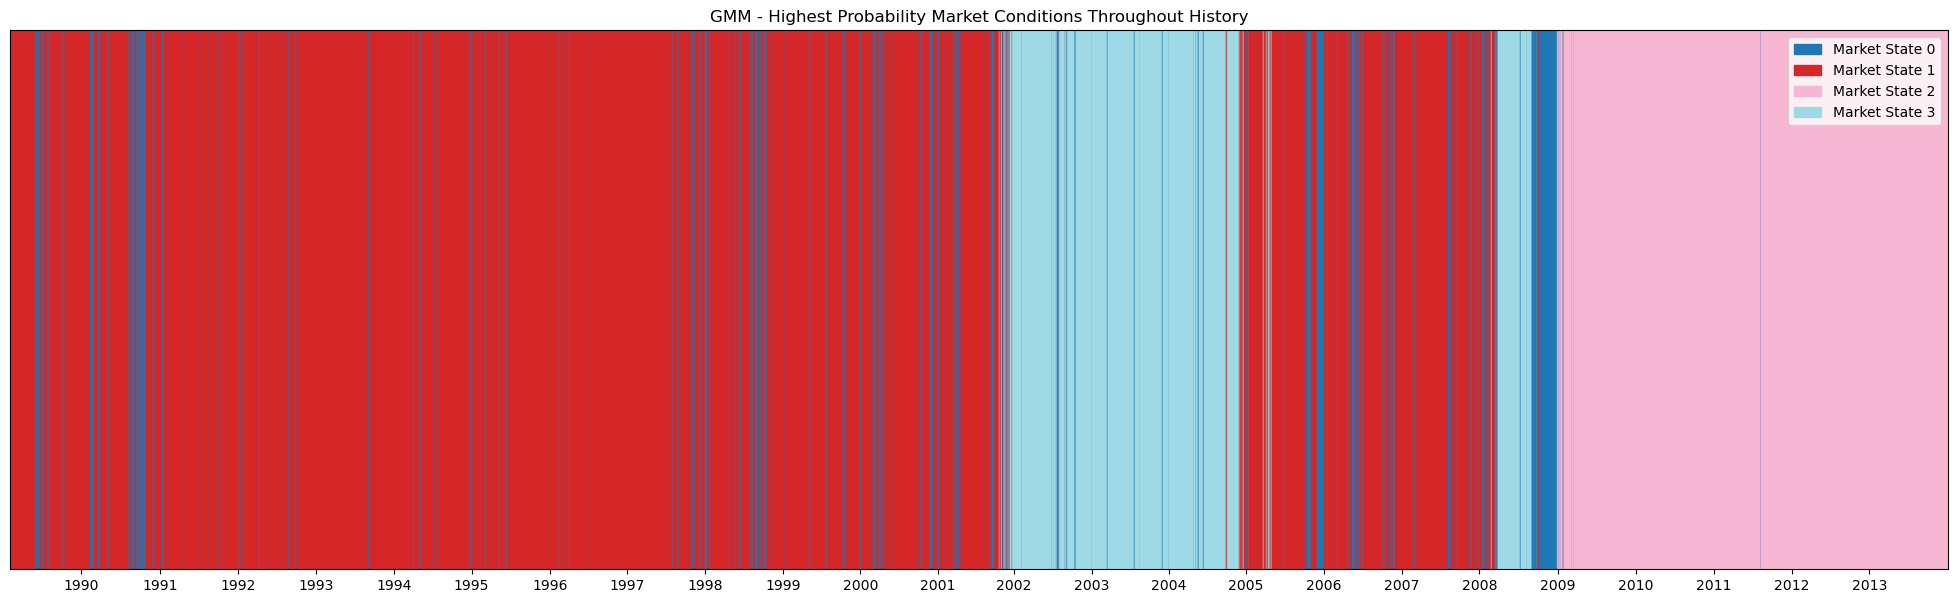

In [13]:
fig, ax = plt.subplots(figsize=(25, 7))

colors_list = plt.colormaps.get_cmap('tab20').resampled(gmm_market_regimes)
rectangle_height = 1

for i, date in enumerate(data_ref.index):
    color = colors_list(gmm_clusters[i])
    rect = patches.Rectangle((i, 0), 1, rectangle_height, color=color)
    ax.add_patch(rect)

years = [date.year for date in data_ref.index]
change_years = [i for i in range(1, len(years)) if years[i] != years[i-1]]
ax.set_xticks(change_years)
ax.set_xticklabels([years[i] for i in change_years])

ax.set_xlim(0, len(data_ref))
ax.set_ylim(0, rectangle_height)
ax.set_yticks([]) 

legend_elements = [
    patches.Patch(color=colors_list(i), label=f'Market State {i}')
    for i in range(gmm_market_regimes)
]
ax.legend(handles=legend_elements, loc='upper right')

ax.set_title('GMM - Highest Probability Market Conditions Throughout History')
plt.show()

**GMM Market Regimes :**

**0 | Severe Crisis** : This regime represents a severe crisis with significant declines in equities, commodities, and emerging markets. High volatility across all asset classes indicates extreme market stress. Interest rates are variable, reflecting central bank interventions.

**1 | Stable Growth** : This regime indicates stable economic growth with moderate interest rates and low volatility across asset classes. Equities, commodities, and emerging markets show positive performance.

**2 | Low Interest Rate Environment** : This regime reflects a low interest rate environment, likely during periods of accommodative monetary policy. Equities and emerging markets perform well, and volatility is moderate.

**3 | Moderate Growth with Moderate Rates** : This regime indicates moderate economic growth with moderate interest rates. Commodities and emerging markets perform well, while equities show slight declines with moderate volatility.


## Hidden Markov Model - HMM

#### AIC & BIC scores - HMM

AIC : best number of market regimes : 12
BIC : best number of market regimes : 12


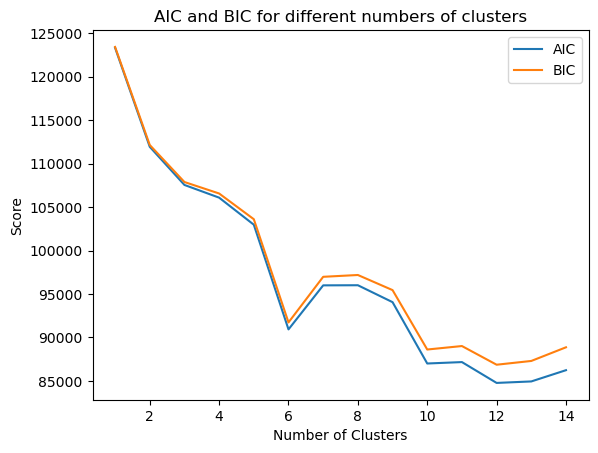

In [14]:
np.random.seed(39)
n_market_regimes = range(1, 15)
hmm_aic_scores = []
hmm_bic_scores = []
n_init = 5

for market_regime in n_market_regimes:
    best_aic = float('inf')
    best_bic = float('inf')

    for _ in range(n_init):
        hm = hmm.GaussianHMM(n_components=market_regime, covariance_type='diag')
        hm.fit(data_ref_scaled)
        current_aic = hm.aic(data_ref_scaled)
        current_bic = hm.bic(data_ref_scaled)

        if current_aic < best_aic:
            best_aic = current_aic
        if current_bic < best_bic:
            best_bic = current_bic

    hmm_aic_scores.append(best_aic)
    hmm_bic_scores.append(best_bic)

print(f"AIC : best number of market regimes : {hmm_aic_scores.index(min(hmm_aic_scores))+1}")
print(f"BIC : best number of market regimes : {hmm_bic_scores.index(min(hmm_bic_scores))+1}")

plt.plot(n_market_regimes, hmm_aic_scores, label='AIC')
plt.plot(n_market_regimes, hmm_bic_scores, label='BIC')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.title('AIC and BIC for different numbers of clusters')
plt.show()

#### Training the model

In [60]:
hmm_market_regimes = 6
reference_hmm = hmm.GaussianHMM(n_components=hmm_market_regimes, covariance_type='diag',random_state=38)
reference_hmm.fit(data_ref_scaled)
hmm_clusters = reference_hmm.predict(data_ref_scaled)
data_ref.loc[:,'HMM_MarketRegime'] = hmm_clusters

#### Characteristics of each market regime

In [16]:
data_ref.groupby('HMM_MarketRegime').count()

,Equity,FX,Commodities,Rates,Inflation,Emerging Markets,US Corporate IG,GMM_MarketRegime
HMM_MarketRegime,,,,,,,,
0,1211,1211,1211,1211,1211,1211,1211,1211
1,874,874,874,874,874,874,874,874
2,1223,1223,1223,1223,1223,1223,1223,1223
3,1479,1479,1479,1479,1479,1479,1479,1479
4,355,355,355,355,355,355,355,355
5,1065,1065,1065,1065,1065,1065,1065,1065


In [17]:
for col in data_ref.columns[:-2]:
    print(col)
    print(data_ref.groupby('HMM_MarketRegime')[col].agg(['mean','min','max','std']))
    print('-'*30)

Equity
                      mean       min        max       std
HMM_MarketRegime                                         
0                 0.005870 -3.651303   3.871952  0.848613
1                 0.011960 -3.296994   2.982689  0.871482
2                 0.086394 -2.976869   3.864009  0.852891
3                 0.025962 -3.133279   3.305462  0.780692
4                -0.340665 -7.821784  11.628673  2.538555
5                 0.072396 -1.145152   1.454255  0.444346
------------------------------
FX
                      mean       min       max       std
HMM_MarketRegime                                        
0                -0.017628 -2.373144  1.846087  0.512390
1                -0.023112 -1.255200  1.726199  0.503443
2                -0.025781 -1.696442  1.700563  0.484789
3                 0.015608 -2.413728  2.805033  0.621687
4                 0.055329 -2.726254  2.519905  0.901086
5                 0.010691 -1.047587  1.023979  0.325175
------------------------------
Commodit

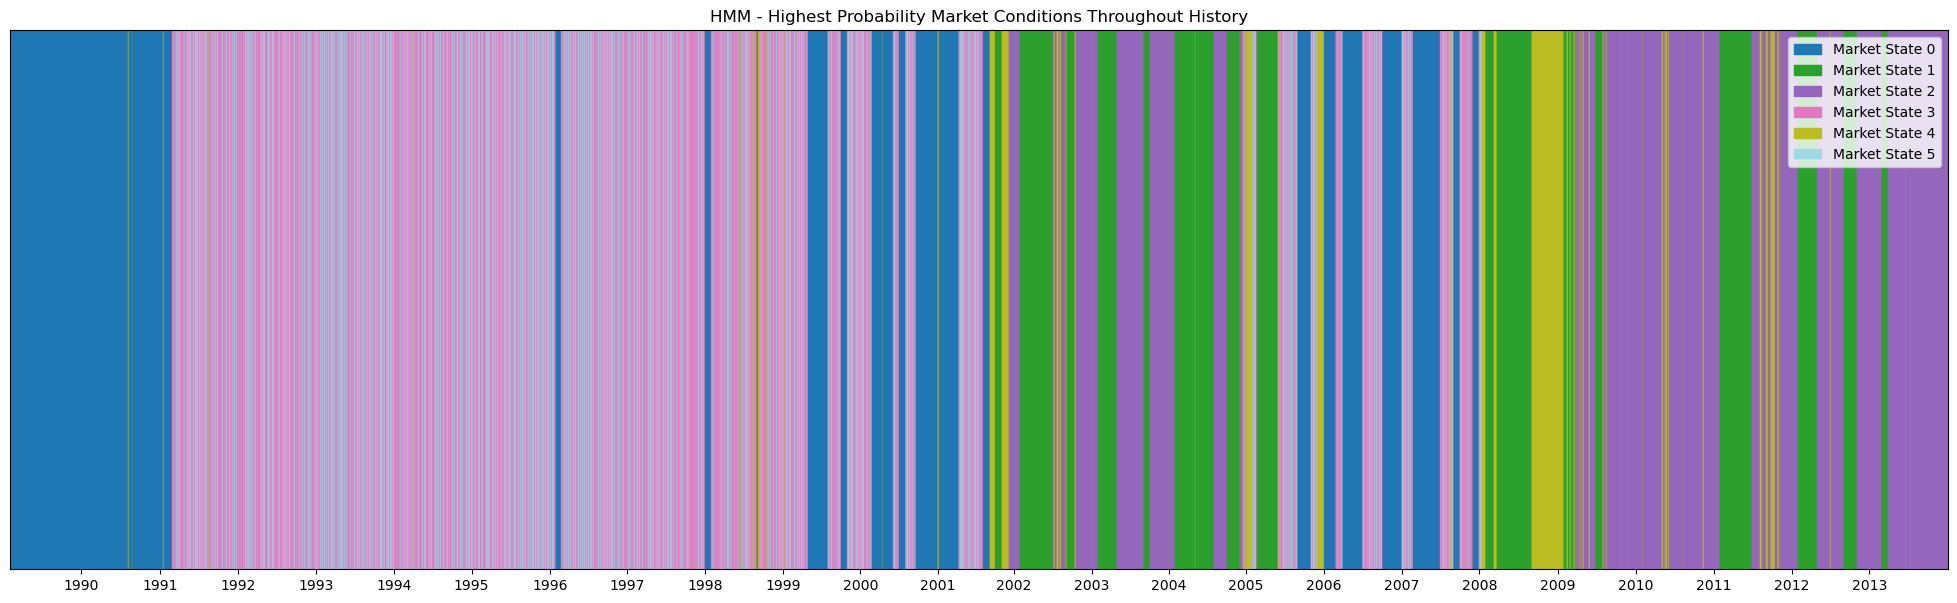

In [18]:
fig, ax = plt.subplots(figsize=(25, 7))

colors_list = plt.colormaps.get_cmap('tab20').resampled(hmm_market_regimes)
rectangle_height = 1

for i, date in enumerate(data_ref.index):
    color = colors_list(hmm_clusters[i])
    rect = patches.Rectangle((i, 0), 1, rectangle_height, color=color)
    ax.add_patch(rect)

years = [date.year for date in data_ref.index]
change_years = [i for i in range(1, len(years)) if years[i] != years[i-1]]
ax.set_xticks(change_years)
ax.set_xticklabels([years[i] for i in change_years])

ax.set_xlim(0, len(data_ref))
ax.set_ylim(0, rectangle_height)
ax.set_yticks([]) 

legend_elements = [
    patches.Patch(color=colors_list(i), label=f'Market State {i}')
    for i in range(hmm_market_regimes)
]
ax.legend(handles=legend_elements, loc='upper right')

ax.set_title('HMM - Highest Probability Market Conditions Throughout History')
plt.show()

**HMM Market Regimes :**

**0 | High Interest Rates with Moderate Growth** : This regime represents a period of high interest rates with moderate economic growth. The relatively high interest rates might be a response to higher inflation. Equities and commodities show slight positive returns, while emerging markets perform moderately well.

**1 | Low Interest Rates with Stable Growth** : This regime indicates a period of low interest rates with stable growth. The low volatility in inflation and moderate performance in equities and emerging markets suggest a stable economic environment with accommodative monetary policy.

**2 | Strong Growth with Low Rates** : This regime reflects strong economic growth with very low interest rates. The strong performance in equities and emerging markets, combined with low inflation, suggests a highly accommodative monetary policy environment.

**3 | Moderate Growth with Moderate Rates** : This regime represents a period of moderate economic growth with moderate interest rates. However, the performance of commodities and emerging markets is mixed, with commodities showing a slight decline and emerging markets exhibiting high volatility.

**4 | Severe Crisis** : This regime represents a severe crisis with significant declines in equities, commodities, and emerging markets. The extremely high volatility across all asset classes indicates extreme market stress. Interest rates are variable, reflecting central bank interventions.

**5 | Balanced Growth with Stable Conditions** : This regime indicates a period of balanced economic growth with stable conditions. The equities and emerging markets perform well with low volatility, suggesting a more stable and favorable economic environment compared to Regime 3. Commodities also show positive returns, and the overall volatility is lower across all asset classes.





## Walk Foward Training

### Parameters - Rolling Training

In [19]:
train_window = 20 # years
test_window = 1 # years
step_window = 1 # years

start_year = dt.datetime(2014,1,2).year
end_year = dt.datetime(2023,12,29).year

gmm_market_regimes = 4
hmm_market_regimes = 6

In [ ]:
clusters = pd.DataFrame(index=data.loc[separation_date:].index,columns=["GMM_Clusters","HMM_Clusters"])

for year in range(start_year, end_year + 1, step_window):
    train_data = data.loc[(data.index.year >= year - train_window) & (data.index.year < year)]
    test_data = data.loc[(data.index.year >= year) & (data.index.year < year + test_window)]
    
    scaler = StandardScaler()
    train_data_scaled = scaler.fit_transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    gmm = GaussianMixture(n_components=gmm_market_regimes, init_params='kmeans')
    gmm.fit(train_data_scaled)
    gmm_clusters_test = reference_gmm.predict(test_data_scaled)

    # Each time we instanciate a gmm, the labels can change.
    # In order, to solve that, we compute the Euclidian distance between the reference clusters and 
    # those predicted for the year to come. This way, we know which labels to modify in order to
    # maintain the same labels throughout the entire preiod.

    distances_gmm = cdist(gmm.means_, reference_gmm.means_, metric="euclidean")
    cluster_mapping_gmm = np.argmin(distances_gmm, axis=1)
    clusters.loc[test_data.index,"GMM_Clusters"] = [cluster_mapping_gmm[elt] for elt in gmm_clusters_test]

    hm = hmm.GaussianHMM(n_components=hmm_market_regimes, covariance_type='diag',random_state=38)
    hm.fit(train_data_scaled)
    hmm_clusters_test = hm.predict(test_data_scaled)

    # Same thing for the hmm

    distances_hmm = cdist(hm.means_, reference_hmm.means_, metric="euclidean")
    cluster_mapping_hmm = np.argmin(distances_hmm, axis=1)
    clusters.loc[test_data.index,"HMM_Clusters"] = [cluster_mapping_hmm[elt] for elt in hmm_clusters_test]
    

### Plot of the GMM & HMM predictions 

#### GMM Predictions 

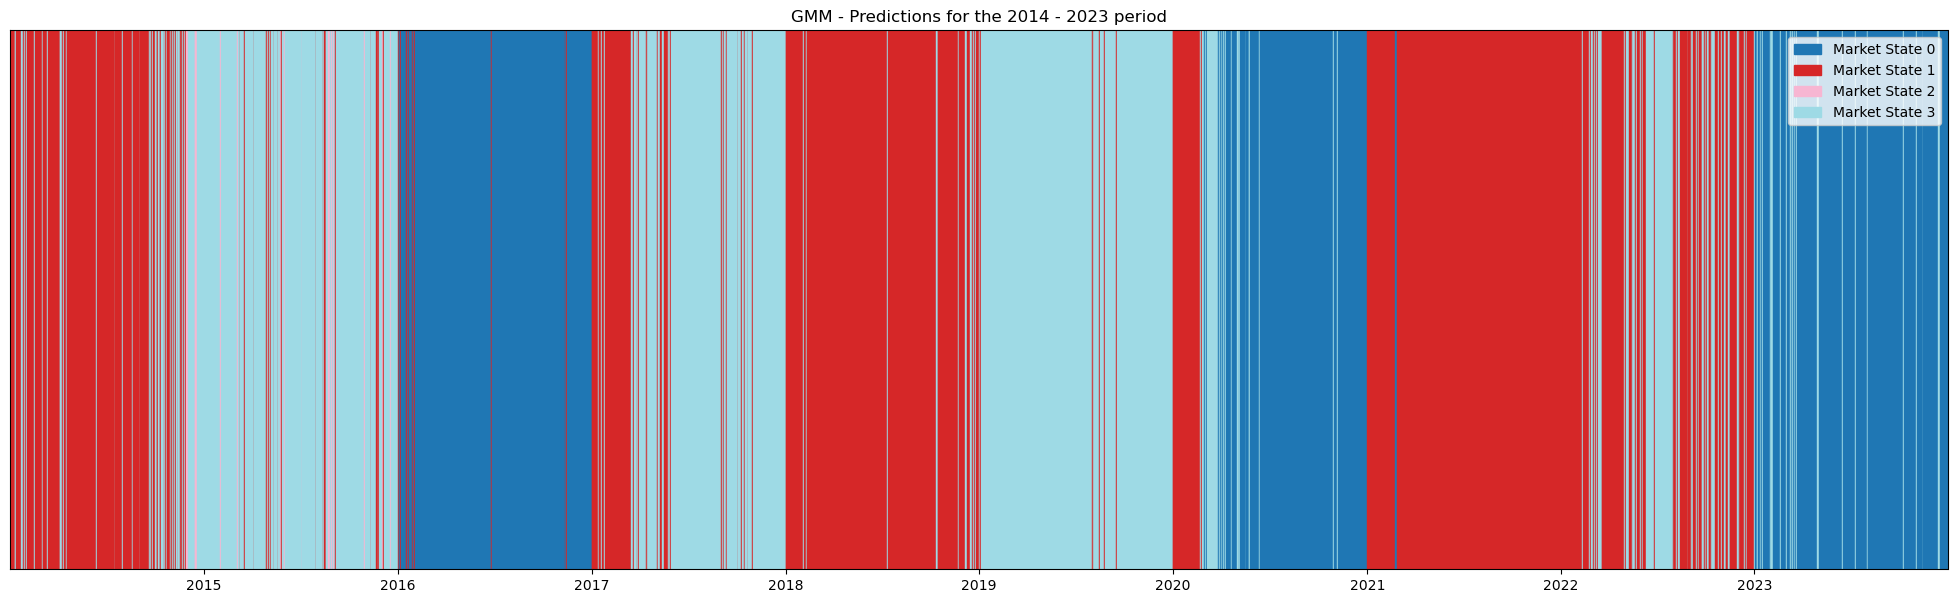

In [21]:
fig, ax = plt.subplots(figsize=(25, 7))

colors_list = plt.colormaps.get_cmap('tab20').resampled(gmm_market_regimes)
rectangle_height = 1

for i, date in enumerate(clusters.index):
    color = colors_list(clusters.loc[date,"GMM_Clusters"])
    rect = patches.Rectangle((i, 0), 1, rectangle_height, color=color)
    ax.add_patch(rect)

years = [date.year for date in clusters.index]
change_years = [i for i in range(1, len(years)) if years[i] != years[i-1]]
ax.set_xticks(change_years)
ax.set_xticklabels([years[i] for i in change_years])

ax.set_xlim(0, len(clusters))
ax.set_ylim(0, rectangle_height)
ax.set_yticks([]) 

legend_elements = [
    patches.Patch(color=colors_list(i), label=f'Market State {i}')
    for i in range(gmm_market_regimes)
]
ax.legend(handles=legend_elements, loc='upper right')

ax.set_title('GMM - Predictions for the 2014 - 2023 period')
plt.show()

**Reminder GMM Market Regimes :**

**0 | Severe Crisis** : This regime represents a severe crisis with significant declines in equities, commodities, and emerging markets. High volatility across all asset classes indicates extreme market stress. Interest rates are variable, reflecting central bank interventions.

**1 | Stable Growth** : This regime indicates stable economic growth with moderate interest rates and low volatility across asset classes. Equities, commodities, and emerging markets show positive performance.

**2 | Low Interest Rate Environment** : This regime reflects a low interest rate environment, likely during periods of accommodative monetary policy. Equities and emerging markets perform well, and volatility is moderate.

**3 | Moderate Growth with Moderate Rates** : This regime indicates moderate economic growth with moderate interest rates. Commodities and emerging markets perform well, while equities show slight declines with moderate volatility.

#### HMM Predictions

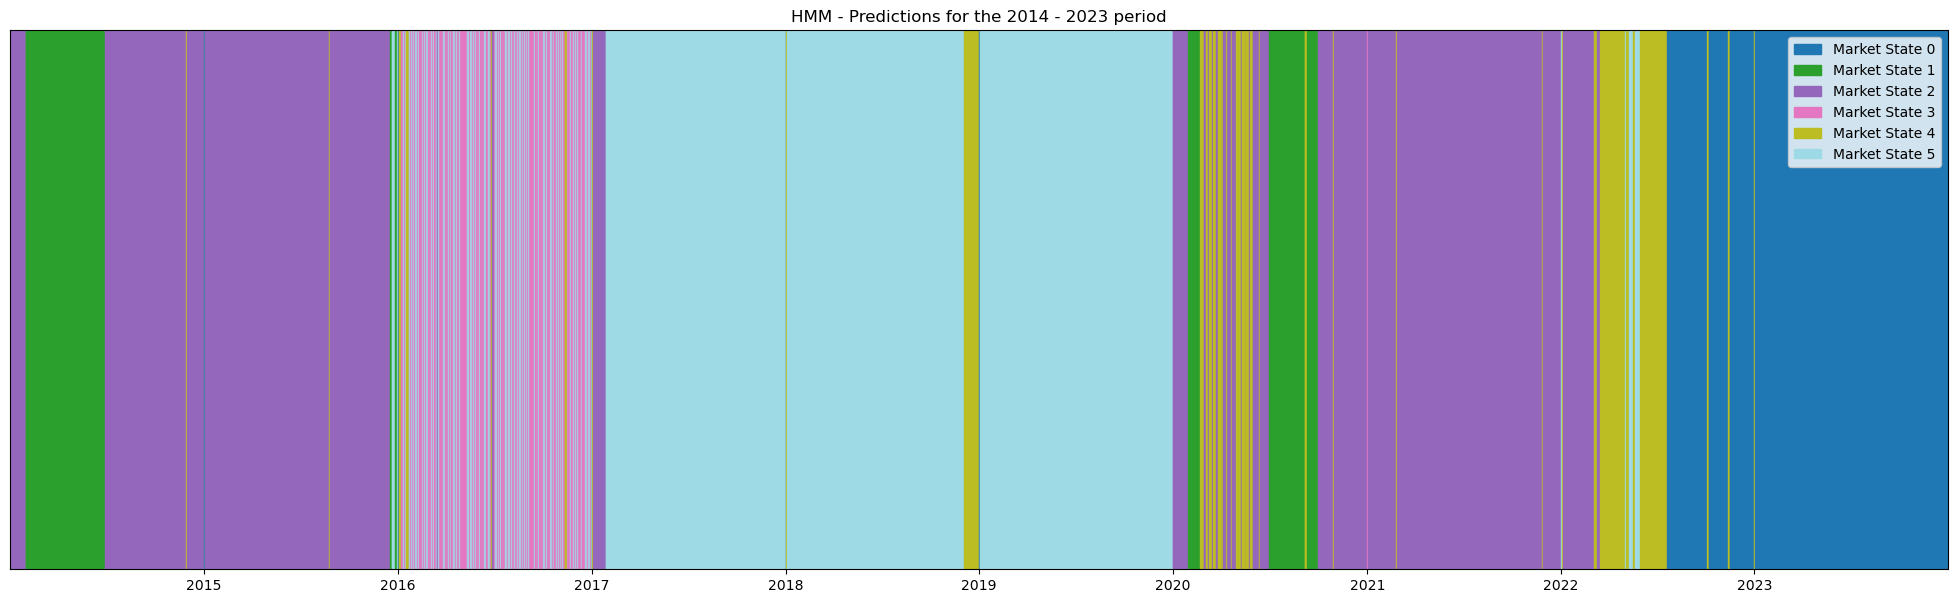

In [22]:
fig, ax = plt.subplots(figsize=(25, 7))

colors_list = plt.colormaps.get_cmap('tab20').resampled(hmm_market_regimes)
rectangle_height = 1

for i, date in enumerate(clusters.index):
    color = colors_list(clusters.loc[date,"HMM_Clusters"])
    rect = patches.Rectangle((i, 0), 1, rectangle_height, color=color)
    ax.add_patch(rect)

years = [date.year for date in clusters.index]
change_years = [i for i in range(1, len(years)) if years[i] != years[i-1]]
ax.set_xticks(change_years)
ax.set_xticklabels([years[i] for i in change_years])

ax.set_xlim(0, len(clusters))
ax.set_ylim(0, rectangle_height)
ax.set_yticks([]) 

legend_elements = [
    patches.Patch(color=colors_list(i), label=f'Market State {i}')
    for i in range(hmm_market_regimes)
]
ax.legend(handles=legend_elements, loc='upper right')

ax.set_title('HMM - Predictions for the 2014 - 2023 period')
plt.show()

**Reminder HMM Market Regimes :**

**0 | High Interest Rates with Moderate Growth** : This regime represents a period of high interest rates with moderate economic growth. The relatively high interest rates might be a response to higher inflation. Equities and commodities show slight positive returns, while emerging markets perform moderately well.

**1 | Low Interest Rates with Stable Growth** : This regime indicates a period of low interest rates with stable growth. The low volatility in inflation and moderate performance in equities and emerging markets suggest a stable economic environment with accommodative monetary policy.

**2 | Strong Growth with Low Rates** : This regime reflects strong economic growth with very low interest rates. The strong performance in equities and emerging markets, combined with low inflation, suggests a highly accommodative monetary policy environment.

**3 | Moderate Growth with Moderate Rates** : This regime represents a period of moderate economic growth with moderate interest rates. However, the performance of commodities and emerging markets is mixed, with commodities showing a slight decline and emerging markets exhibiting high volatility.

**4 | Severe Crisis** : This regime represents a severe crisis with significant declines in equities, commodities, and emerging markets. The extremely high volatility across all asset classes indicates extreme market stress. Interest rates are variable, reflecting central bank interventions.

**5 | Balanced Growth with Stable Conditions** : This regime indicates a period of balanced economic growth with stable conditions. The equities and emerging markets perform well with low volatility, suggesting a more stable and favorable economic environment compared to Regime 3. Commodities also show positive returns, and the overall volatility is lower across all asset classes.





## Implementation of strategies

The aim of this part is to backtest several strategies from 2014-01-02 to 2023-12-29.

At each date, we are going take the estimated market regime from the previous observation (otherwie data leakage) and implement a strategy based on the characteristics of the market regime. Then we are going to compare the results (Returns, Max Drawdown, Sharpe Ratio, Standard Deviation) to the results of others strategies that are not based with the market regime (ex: Buy & Hold Strategy).

In [23]:
start_date = dt.datetime(2014,1,2)
end_date = dt.datetime(2023,12,29)
interval_date = "1d"

In [24]:
def get_data(market_regimes: pd.DataFrame, ticker: str, start: dt.datetime = start_date, end: dt.datetime = end_date, interval: str = "1d") -> pd.DataFrame:
    """
    Retrieve data from yahoo and add the gmm or hmm market regimes
    """
    df = yf.download(tickers=ticker, start=start, end=end, interval=interval,auto_adjust=True)
    df = df.droplevel(level=1,axis=1)
    df[market_regimes.columns] = market_regimes.reindex(index=df.index, method="ffill")
    return df

In [25]:
class MarketRegimesData(bt.feeds.PandasData):
         lines = ("GMM_Clusters","HMM_Clusters",)
         params = (
             ("GMM_Clusters", -1),
             ("HMM_Clusters", -1)
         )

In [26]:
class MarketRegimesGMM(bt.Strategy):

    def __init__(self):
        self.gmm_regimes = self.datas[0].GMM_Clusters   
        self.weights = {
            0 : {"equity" : 0.0, "fx" : 0.0, "rates" : 0.5, "emerging_markets": 0.0, "commodity": 0.0, "Cash":0.5},
            1 : {"equity" : 0.6, "fx" : 0.0, "rates" : 0.0, "emerging_markets": 0.2, "commodity": 0.2, "Cash":0.0},
            2 : {"equity" : 0.5, "fx" : 0.0, "rates" : 0.0, "emerging_markets": 0.5, "commodity": 0.0, "Cash":0.0},
            3 : {"equity" : 0.0, "fx" : 0.0, "rates" : 0.7, "emerging_markets": 0.0, "commodity": 0.0, "Cash":0.3},
        }    

    def rebalance_portfolio(self, regime):
        weights = self.weights.get(regime, {"Equity": 0.5, "Cash": 0.5})
        for asset, target_weight in weights.items():
            if asset != "Cash":
                self.order_target_percent(data=asset ,target=target_weight)

    def next(self):

        if len(self) < 2:
            return

        if self.gmm_regimes[-1] == self.gmm_regimes[-2] and self.gmm_regimes[-2] != self.gmm_regimes[-3]:
            self.rebalance_portfolio(self.gmm_regimes[-1])


In [ ]:
class MarketRegimesHMM(bt.Strategy):

    def __init__(self):
        self.hmm_regimes = self.datas[0].HMM_Clusters   
        self.weights = {
            0 : {"equity" : 0.3, "fx" : 0.0, "rates" : 0.0, "emerging_markets": 0.2, "commodity": 0.2, "Cash":0.3},
            1 : {"equity" : 0.4, "fx" : 0.0, "rates" : 0.0, "emerging_markets": 0.2, "commodity": 0.2, "Cash":0.2},
            2 : {"equity" : 0.5, "fx" : 0.0, "rates" : 0.0, "emerging_markets": 0.5, "commodity": 0.0, "Cash":0.0},
            3 : {"equity" : 0.3, "fx" : 0.0, "rates" : 0.5, "emerging_markets": 0.0, "commodity": 0.0, "Cash":0.2},
            4 : {"equity" : 0.0, "fx" : 0.3, "rates" : 0.4, "emerging_markets": 0.0, "commodity": 0.0, "Cash":0.3},
            5 : {"equity" : 0.4, "fx" : 0.0, "rates" : 0.2, "emerging_markets": 0.4, "commodity": 0.0, "Cash":0.0},
        }    

    def rebalance_portfolio(self, regime):
        weights = self.weights.get(regime, {"Equity": 0.5, "Cash": 0.5})
        for asset, target_weight in weights.items():
            if asset != "Cash":
                self.order_target_percent(data=asset ,target=target_weight)

    def next(self):

        if len(self) < 3:
            return

        # we need to have the same market regime for at least 2 consecutive days in order to rebalance the portfolio.
        if self.hmm_regimes[-1] == self.hmm_regimes[-2] and self.hmm_regimes[-2] != self.hmm_regimes[-3]:
            self.rebalance_portfolio(self.hmm_regimes[-1])


In [50]:
class BuyAndHold(bt.Strategy):

    def next(self):
        if not self.position:
            self.buy(data="equity")


In [51]:
def run_strategy(strategy_class, data, name):
    
    cerebro = bt.Cerebro()
    
    cerebro.addstrategy(strategy_class)

    for elt in data:
        cerebro.adddata(elt)
    
    cerebro.broker.setcash(1000000.0)
    cerebro.broker.setcommission(commission=0.001) 
    cerebro.broker.set_slippage_perc(perc=0.001) 

    # cerebro.addsizer(bt.sizers.AllInSizer)
    cerebro.addsizer(bt.sizers.AllInSizerInt)
    #cerebro.addsizer(bt.sizers.PercentSizer, percents = 30)

    cerebro.addanalyzer(bt.analyzers.Returns, _name = "returns")
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe', riskfreerate=0.0)
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
    cerebro.addanalyzer(bt.analyzers.PeriodStats, _name='periodstats')
    cerebro.addanalyzer(bt.analyzers.PyFolio)
    
    results = cerebro.run()
    strat = results[0]

    rtot_log =  strat.analyzers.returns.get_analysis().get("rtot")
    
    return {
        "name": name,
        "start_value" : cerebro.broker.startingcash,
        "final_value": cerebro.broker.getvalue(),
        "total_return_pct": (np.exp(rtot_log)-1)*100,
        "annualized_return_pct": strat.analyzers.returns.get_analysis().get("rnorm100"),
        "sharpe": strat.analyzers.sharpe.get_analysis().get('sharperatio', None),
        "max_drawdown": strat.analyzers.drawdown.get_analysis().max.drawdown,
        "total_trades": strat.analyzers.trades.get_analysis().total.total,
        "number_positive_years" : strat.analyzers.periodstats.get_analysis().get("positive"),
        "number_negative_years" : strat.analyzers.periodstats.get_analysis().get("negative"),
        "number_flat_years" : strat.analyzers.periodstats.get_analysis().get("nochange"),
        "best_year_perf_pct" : strat.analyzers.periodstats.get_analysis().get("best") * 100,
        "worst_year_perf_pct" : strat.analyzers.periodstats.get_analysis().get("worst") * 100,
        "average_annual_return_pct" : strat.analyzers.periodstats.get_analysis().get("average") * 100,
        "annual_std_pct" : strat.analyzers.periodstats.get_analysis().get("stddev") * 100,
        "pyfolio" : strat.analyzers.getbyname("pyfolio") 
    }

## Main

In [57]:
if __name__ == "__main__":

    ## Data

        # S&P 500 index
    equity_df = get_data(clusters,"^GSPC", start_date, end_date, interval_date) 
    equity_test = MarketRegimesData(dataname=equity_df, name="equity")

        # TLT (iShares 20+ Year Treasury Bond)
    rates_df = get_data(clusters,"TLT", start_date, end_date, interval_date) 
    rates_test = MarketRegimesData(dataname=rates_df, name="rates")

        # EEM (iShares MSCI Emerging Markets)
    em_df = get_data(clusters, "EEM", start_date, end_date, interval_date) 
    em_test = MarketRegimesData(dataname=em_df, name="emerging_markets")

        # UUP (DXY index ETF)
    fx_df = get_data(clusters, "UUP", start_date, end_date, interval_date) 
    fx_test = MarketRegimesData(dataname=fx_df, name="fx")

        # DBC (Invesco DB Commodity Index Tracking)
    commodity_df = get_data(clusters, "DBC", start_date, end_date, interval_date) 
    commodity_test = MarketRegimesData(dataname=commodity_df, name="commodity")

        # Data to add to Cerebro
    bh_data_test = [equity_test]
    gmm_data_test = [equity_test, rates_test, em_test, fx_test, commodity_test]
    hmm_data_test = [equity_test, rates_test, em_test, fx_test, commodity_test]

    ## Time
    print("\n",f"start : {start_date.date()} | end : {end_date.date()}")

    ## Strategies
    stats_BH = run_strategy(BuyAndHold,bh_data_test,"Buy & Hold")
    stats_GMM = run_strategy(MarketRegimesGMM,gmm_data_test,"GMM Market Regimes")
    stats_HMM = run_strategy(MarketRegimesHMM,hmm_data_test,"HMM Market Regimes")

    ## Stats
    print("\n" + "="*90)
    print(f"{'Metrics':<25} | {stats_BH['name'] :<25} | {stats_GMM['name']:<25} | {stats_HMM['name']:<25}")
    print("-" * 90)
    
    metrics = [
        ("Start Value ($)", "start_value", "{:,.2f}"),
        ("Final Value ($)", "final_value", "{:,.2f}"),
        ("Total Return", "total_return_pct", "{:.2f}%"),
        ("Annualized Return", "annualized_return_pct", "{:.2f}%"),
        ("Best Annual Perf","best_year_perf_pct","{:.2f}%"),
        ("Worst Annual Perf","worst_year_perf_pct","{:.2f}%"),
        ("Annualized volatility","annual_std_pct","{:.2f}%"),
        ("Sharpe Ratio", "sharpe", "{:.3f}"),
        ("Max Drawdown", "max_drawdown", "{:.2f}%"),
        ("Total Trades", "total_trades", "{}"),
        ("Positif Years","number_positive_years","{}"),
        ("Negatif Years","number_negative_years","{}"),
        ("Flat Years","number_flat_years","{}"),
    ]

    for label, key, fmt in metrics:
        val1 = stats_BH[key]
        val2 = stats_GMM[key]
        val3 = stats_HMM[key]
        
        v1_str = fmt.format(val1) if val1 is not None else "N/A"
        v2_str = fmt.format(val2) if val2 is not None else "N/A"
        v3_str = fmt.format(val3) if val3 is not None else "N/A"
        
        print(f"{label:<25} | {v1_str:<25} | {v2_str:<25} | {v3_str:<25}")
    print("="*90)



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



 start : 2014-01-02 | end : 2023-12-29

Metrics                   | Buy & Hold                | GMM Market Regimes        | HMM Market Regimes       
------------------------------------------------------------------------------------------
Start Value ($)           | 1,000,000.00              | 1,000,000.00              | 1,000,000.00             
Final Value ($)           | 2,592,615.90              | 1,019,891.72              | 1,311,155.59             
Total Return              | 159.26%                   | 1.99%                     | 31.12%                   
Annualized Return         | 10.02%                    | 0.20%                     | 2.75%                    
Best Annual Perf          | 28.88%                    | 8.39%                     | 11.27%                   
Worst Annual Perf         | -19.44%                   | -4.99%                    | -7.74%                   
Annualized volatility     | 14.90%                    | 3.92%                     | 6.57%         

In [58]:
gmm_pyfolio = stats_GMM["pyfolio"]
gmm_returns, gmm_positions, gmm_transactions, gmm_gross_lev = gmm_pyfolio.get_pf_items()

hmm_pyfolio = stats_HMM["pyfolio"]
hmm_returns, hmm_positions, hmm_transactions, hmm_gross_lev = hmm_pyfolio.get_pf_items()

bh_returns = equity_df["Close"].pct_change().dropna()

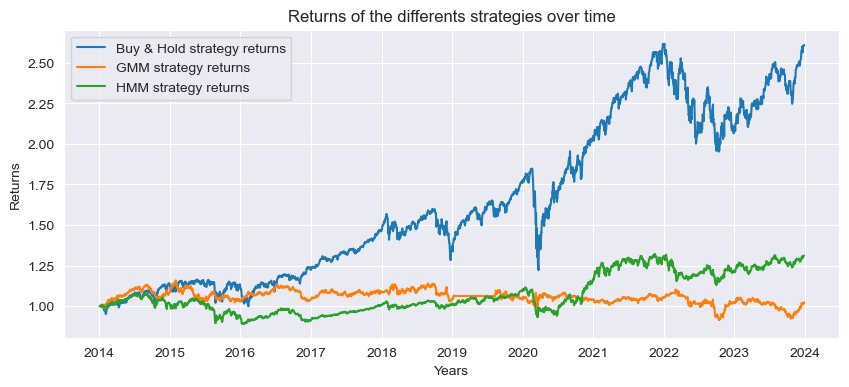

In [64]:
sns.set_style("darkgrid")

plt.figure(figsize=(10,4))
plt.plot((bh_returns+1).cumprod())
plt.plot((gmm_returns+1).cumprod())
plt.plot((hmm_returns+1).cumprod())
plt.legend(["Buy & Hold strategy returns", "GMM strategy returns","HMM strategy returns"])
plt.xlabel("Years")
plt.ylabel("Returns")
plt.title("Returns of the differents strategies over time")

plt.show()

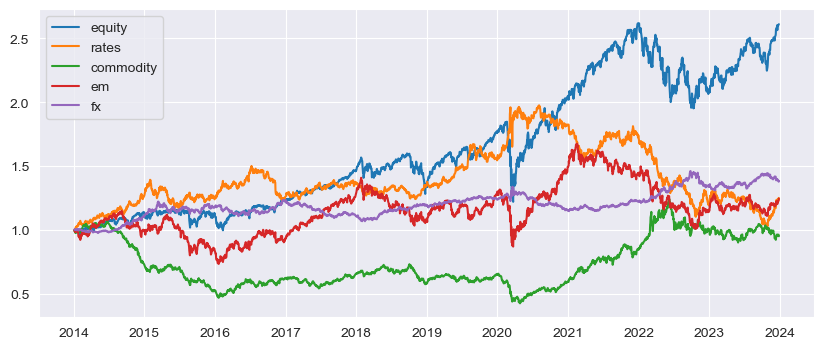

In [65]:
equity = equity_df["Close"].pct_change().dropna()
commo = commodity_df["Close"].pct_change().dropna()
em = em_df["Close"].pct_change().dropna()
rates = rates_df["Close"].pct_change().dropna()
fx = fx_df["Close"].pct_change().dropna()


plt.figure(figsize=(10,4))
plt.plot((equity+1).cumprod())
plt.plot((rates+1).cumprod())
plt.plot((commo+1).cumprod())
plt.plot((em+1).cumprod())
plt.plot((fx+1).cumprod())
plt.legend(["equity","rates","commodity","em","fx"])

plt.show()